In [5]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import pandas as pd

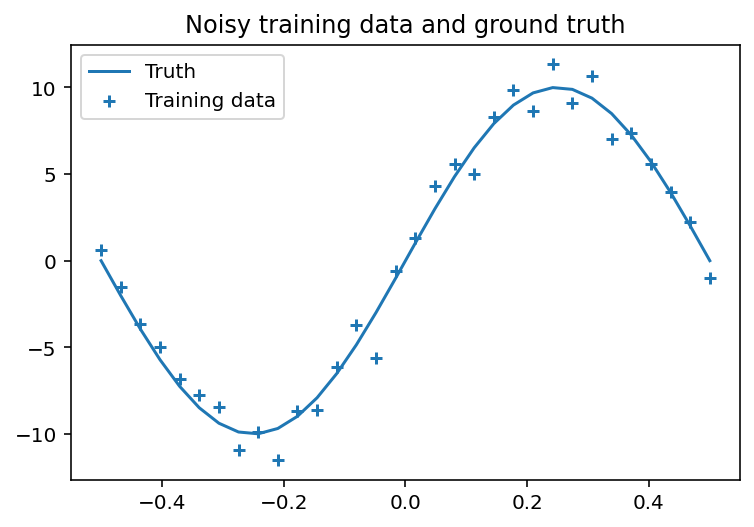

In [294]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [304]:
pd.DataFrame.from_dict({'x':X.ravel(),'y':y.ravel()},orient='columns').to_csv('nice.csv',index=False)

## Take 2 (dataset change)

In [159]:
# Why just the negative log likelihood?
negloglik = lambda y_true, rv_y: -rv_y.log_prob(y_true)

In [224]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(2),
    tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[:, :1],
                           scale=1e-1 + tf.math.softplus(0.05 * t[:,1:]))),
])

In [225]:
model.compile(loss=negloglik)
model.fit(X,y,epochs=1500,verbose=0)

In [226]:
X_test = np.linspace(0,1,100).reshape(-1,1)

In [227]:
# Output is still a distribution, but a useless one
yhat = model(X_test)
y_preds = yhat.sample(50).numpy().squeeze()
y_mean = y_preds.mean(axis=0)
y_sigma = y_preds.std(axis=0)

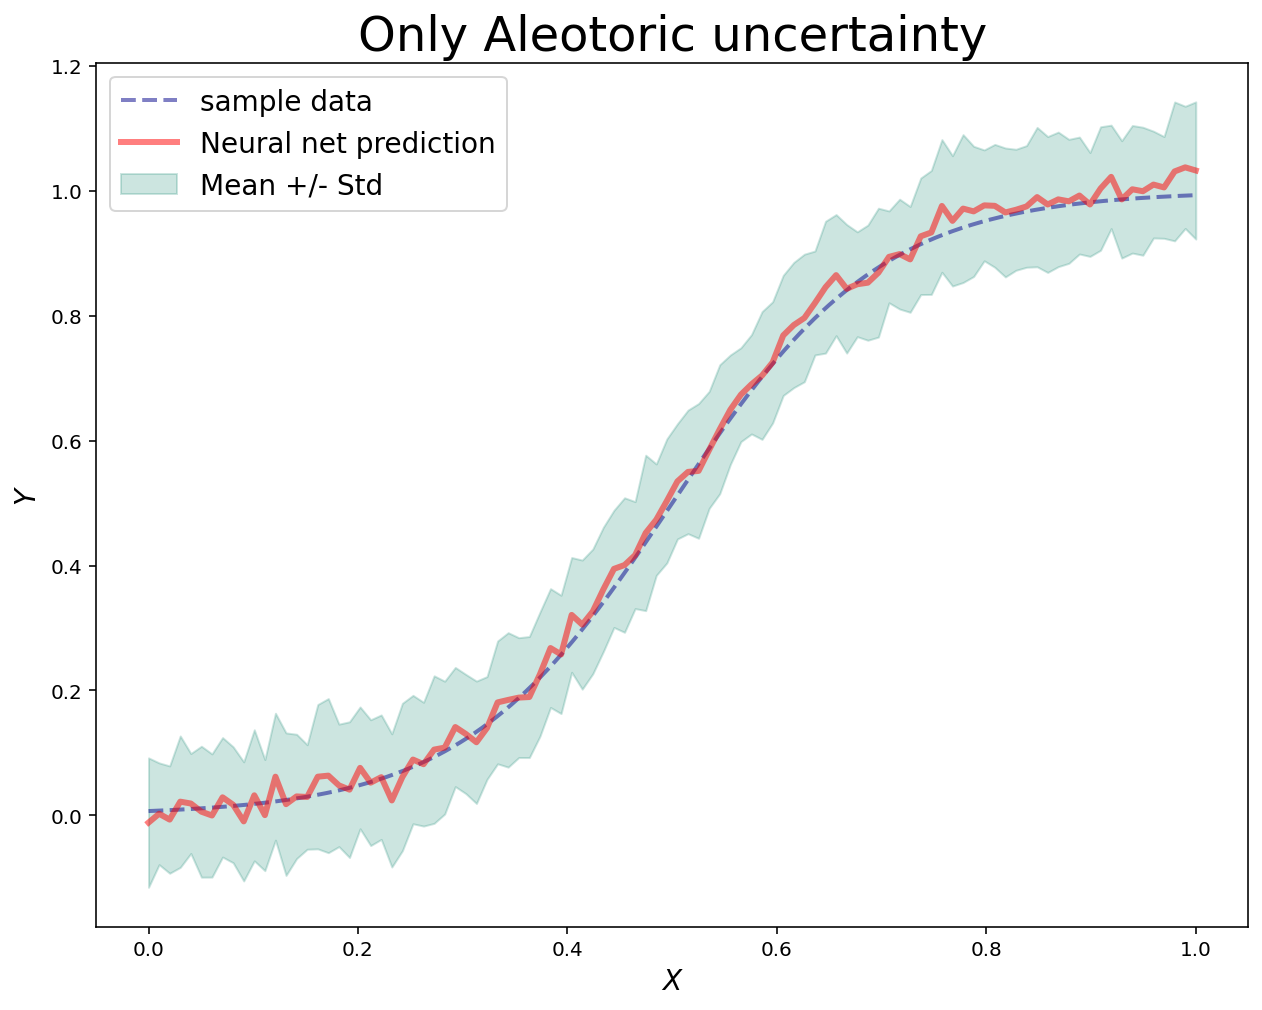

In [228]:
plt.figure(figsize=(4,6))
plt.plot(X, y,'--',color='darkblue' ,lw=2, alpha = 0.5, label='sample data')
plt.plot(X_test, y_mean,color='r',lw=3, alpha = 0.5, label='Neural net prediction')
plt.fill_between(X_test.ravel(), y_mean+y_sigma, y_mean-y_sigma, color="#007D66", \
                alpha=0.2,label = 'Mean +/- Std')
plt.title('Only Aleotoric uncertainty',fontsize=24); 
plt.xlabel('$X$',fontsize=14); 
plt.ylabel('$Y$',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend(fontsize=14)
plt.show()

## Imports

In [118]:
from tensorflow.keras import backend as K # Need to check if this can be avoided
from tensorflow.keras.layers import Layer # Some abstraction to add weights
import tensorflow as tf

# Get functional API, and optimizer
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [119]:
# Refer to segment 3.4 equation (8)

kl_loss_weight = 1.0

In [211]:
# Below block of code is just to define some nice functions to get the trainable variables ready

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.exp(1.)-1)
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

In [230]:
kl_loss_weight = 0.1

In [231]:
# We're using Dense Variational layers
# Unlike regular dense layers, these take posteriors (q(w/0))
# and priors P(w)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(units=120,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu',use_bias=False),
    tfp.layers.DenseVariational(units=120,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,
                                activation='relu'),
    tfp.layers.DenseVariational(units=1,
                                make_posterior_fn=posterior_mean_field,
                                make_prior_fn=prior_trainable,
                                kl_weight=kl_loss_weight,use_bias=True)
])

In [232]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_60 (DenseV (None, 120)               360       
_________________________________________________________________
dense_variational_61 (DenseV (None, 120)               43560     
_________________________________________________________________
dense_variational_62 (DenseV (None, 1)                 363       
Total params: 44,283
Trainable params: 44,283
Non-trainable params: 0
_________________________________________________________________


In [233]:
# This is just a simple loss function
# Taking the negative log likelihood
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

In [234]:
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.01), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

In [235]:
import tqdm

In [236]:
X_test = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred_list = []
for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    

100%|██████████| 500/500 [00:15<00:00, 31.27it/s]


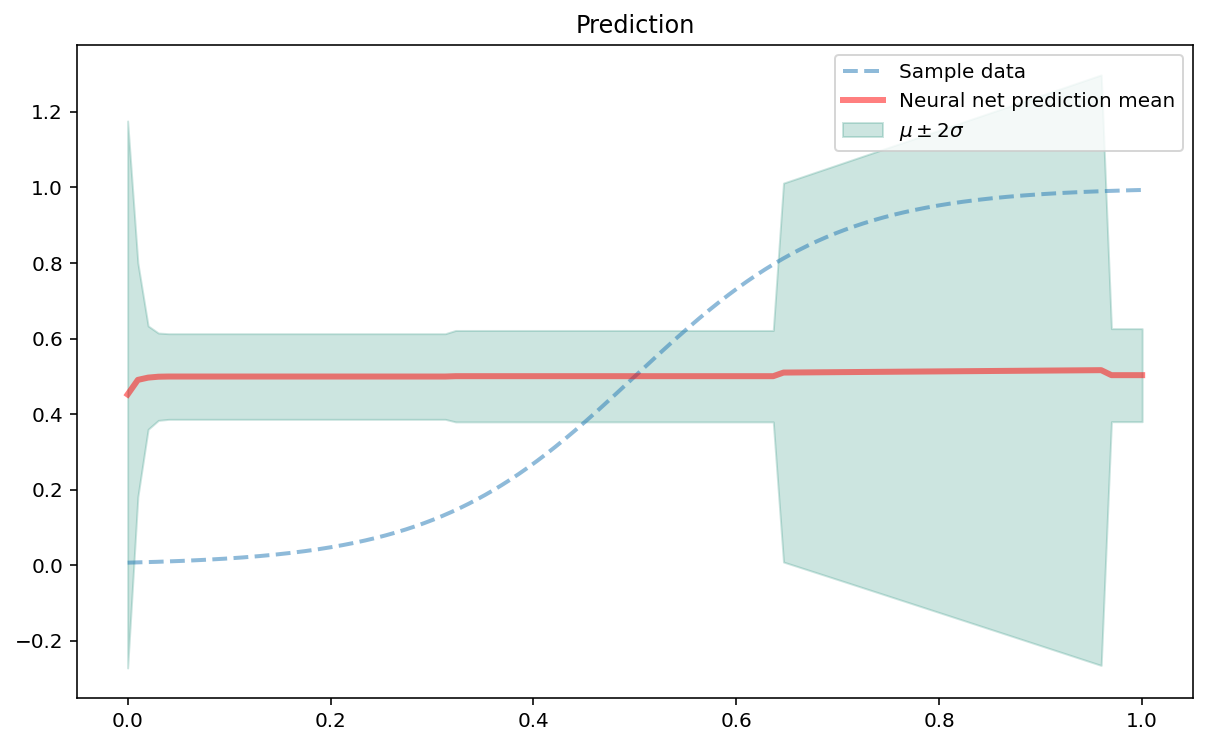

In [237]:
plt.figure(figsize=(10,6))
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X, y,'--', label='Sample data',lw=2,alpha=0.5)
plt.plot(X_test, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(X_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm 2\sigma$')
plt.title('Prediction')
plt.legend();

In [281]:
# We're using Dense Variational layers
# Unlike regular dense layers, these take posteriors (q(w/0))
# and priors P(w)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseFlipout(units=32,
                                activation='relu'),
    tfp.layers.DenseFlipout(units=32,
                                activation='relu'),
    tfp.layers.DenseFlipout(units=1)
])

/Users/hargunoberoi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [282]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_29 (DenseFlipo (None, 32)                96        
_________________________________________________________________
dense_flipout_30 (DenseFlipo (None, 32)                2080      
_________________________________________________________________
dense_flipout_31 (DenseFlipo (None, 1)                 65        
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [283]:
# This is just a simple loss function
# Taking the negative log likelihood
from keras import callbacks, optimizers

def neg_log_likelihood(y_true, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_true))

In [284]:
batch_size=16

In [285]:
model.compile(loss=neg_log_likelihood, optimizer=Adam(lr=0.001), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=500, verbose=0);

In [286]:
import tqdm

In [287]:
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred_list = []
for i in tqdm.tqdm(range(100)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    

100%|██████████| 100/100 [00:05<00:00, 19.86it/s]


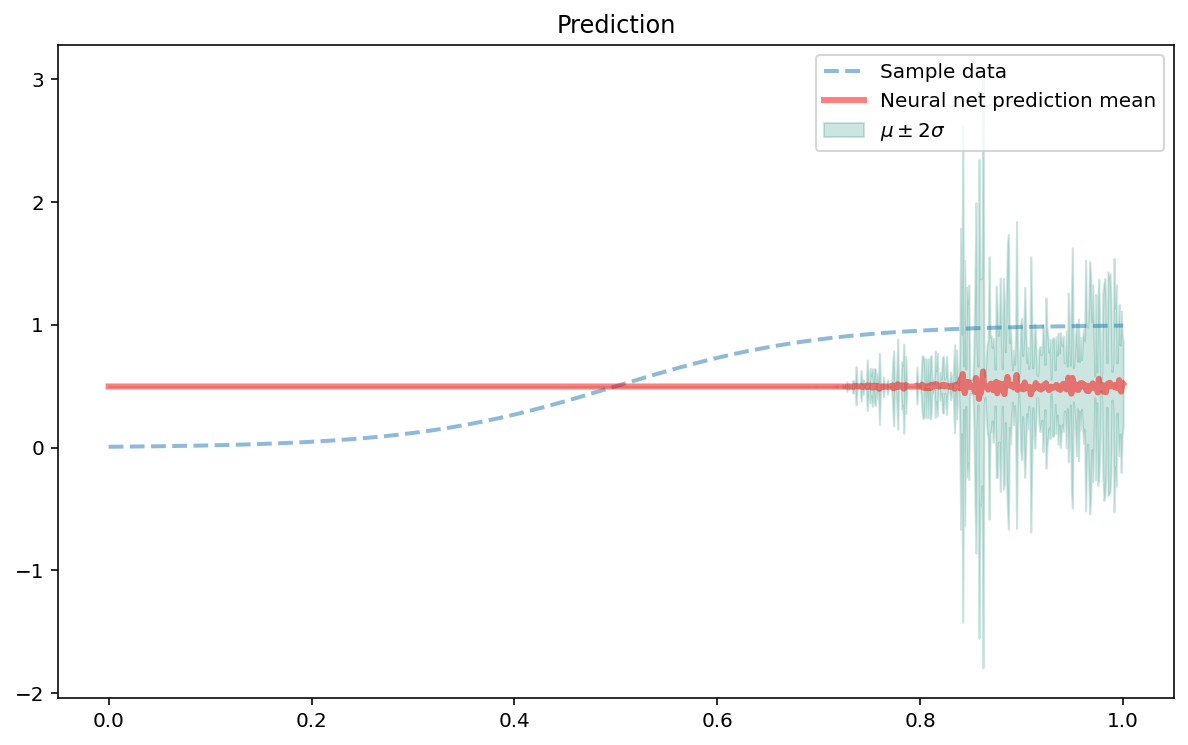

In [293]:
plt.figure(figsize=(10,6))
y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X, y,'--', label='Sample data',lw=2,alpha=0.5)
plt.plot(X_test, y_mean, 'r-', label='Neural net prediction mean', alpha=0.5, lw=3);

plt.fill_between(X_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma, color = '#007D66',
                 alpha=0.2, label=f'$\mu \pm 2\sigma$')
plt.title('Prediction')
plt.legend();

## Questions:

1. What is mean field?
- Something to do with the weights
2. What is `tfp.layers.VariableLayer`?
- Just makes variables
3. What is `softplus`? 
- Some RELU variant
4. What's the difference between `tfd.Normal` & `tfd.distributions.Normal`?

## Notes:

1. We assume that the weights are **not** correlated